In [47]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from model import resnet34
import glob
from sklearn.metrics import classification_report, confusion_matrix
import scipy.io as sio
import spectral

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
class_num = 16
batch_size = 32

In [4]:
data_dir= "E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D"
data_root = glob.glob(data_dir + '/*')
for name in glob.glob(data_dir + '/*'):
    print(name)

E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\data.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\data_label.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\test.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\test_label.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\train.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\train_label.npy


In [5]:
test = np.load(data_root[2])
test_label = np.load(data_root[3])
test_label_onehot = tf.keras.utils.to_categorical(test_label)
test.shape, test_label.shape

((50929, 9, 9, 204), (50929,))

In [14]:
# 实例化模型
feature = resnet34(im_width=9, im_height=9, num_classes=class_num, include_top=False)
feature.trainable = False

model = tf.keras.Sequential([feature,
                             tf.keras.layers.GlobalAvgPool2D(),
                             tf.keras.layers.Dropout(rate=0.5),
                             tf.keras.layers.Dense(1024, activation="relu"),
                             tf.keras.layers.Dropout(rate=0.5),
                             tf.keras.layers.Dense(16),
                             tf.keras.layers.Softmax()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 1, 1, 512)         21932032  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                16400     
_________________________________________________________________
softmax_1 (Softmax)          (None, 16)               

In [15]:
# model.build((None, 224, 224, 3))  # when using subclass model
model.load_weights('./save_weights/myResNet.ckpt')

In [36]:
# using keras low level api for training
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
# metricser = tf.keras.metrics.Mean()

In [37]:
model.compile(optimizer=optimizer,loss=loss_object, metrics=['acc'])

In [38]:
model.evaluate(test, test_label_onehot, batch_size=32)

1592/1592 [==============================] - 13s 8ms/step - loss: 0.4619 - acc: 0.8261 - mean: 0.0000e+00


[0.46187692880630493, 0.8260519504547119, 0.0, 0.0]

In [39]:
# Get the model evaluation report, 
# include classification report, confusion matrix, Test_Loss, Test_accuracy
target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
           ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
            'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
           'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
           'Stone-Steel-Towers']
def reports(test,test_label, test_label_onehot):
    Y_pred_label = model.predict(test)
    # 概率最大的值的位置就为预测的类别
    y_pred_label = np.argmax(Y_pred_label, axis=1)

    # 分类报告：precision    recall  f1-score   support
    classification = classification_report(test_label, y_pred_label, target_names=target_names)
    # 混淆矩阵
    matrix = confusion_matrix(test_label, y_pred_label)
    # 模型得分
    score = model.evaluate(test, test_label_onehot, batch_size=32)
    test_loss = score[0]*100
    overall_accuracy = score[1]*100
    
    return classification, matrix, test_loss, overall_accuracy

In [40]:
# calculate result, loss, accuray and confusion matrix
classification, matrix, test_loss, overall_accuracy = reports(test,test_label, test_label_onehot)

1592/1592 [==============================] - 12s 8ms/step - loss: 0.4619 - acc: 0.8261 - mean: 0.0000e+00


In [41]:
def save_result(classification, matrix, test_loss):
    classification = str(classification)
    matrix_str = str(matrix)

    # 类别精度
    accuracy_list = []
    for i in range(len(matrix)):
        ac = matrix[i, i] / sum(matrix[:, i])
        accuracy_list.append(ac)

    total_right = np.sum(np.trace(matrix))

    # kappa
    kk = 0
    for i in range(matrix.shape[0]):
        kk += np.sum(matrix[i]) * np.sum(matrix[:, i])
    pe = kk / (np.sum(matrix) * np.sum(matrix))
    pa = np.trace(matrix) / np.sum(matrix)
    kappa = (pa - pe) / (1 - pe)

    # OA and AA
    accuracy_list = np.asarray(accuracy_list)
    aa = np.mean(accuracy_list)
    oa = np.sum(np.trace(matrix)) / np.sum(matrix)

    if not os.path.exists('result'):
        os.mkdir('result')
    file_name = "./result/report.txt"
    with open(file_name, 'w') as x_file:
        for i in range(len(matrix)):
            accuracy_list = []
            ac = matrix[i, i] / sum(matrix[:, i])
            accuracy_list.append(ac)
            x_file.write('{} class: matrix[{}, {}] / sum(matrix[:, {}] {}'.format(i+1, i+1, i+1, i+1, ac))
            x_file.write('\n')
        x_file.write('\n')
        x_file.write(" classification result: \n")
        x_file.write('{}'.format(classification))
        x_file.write('\n')
        x_file.write(" confusion matrix: \n")
        x_file.write('{}'.format(matrix_str))

        x_file.write('\n')
        x_file.write('oa {}'.format(oa))
        x_file.write('\n')
        x_file.write('aa {}'.format(aa))
        x_file.write('\n')
        x_file.write('kappa {}'.format(kappa))
        x_file.write('\n')
        x_file.write('Test loss {} (%)'.format(test_loss))
        x_file.write('\n')

In [42]:
save_result(classification, matrix, test_loss)

In [48]:
data = np.load(data_root[0])
data_label = np.load(data_root[1])
data_gt_dict = sio.loadmat(r"E:\Eric_HSI\hyperspectral_datasets\Salinas_gt.mat")
data_gt_name = [t for t in list(data_gt_dict.keys()) if not t.startswith('__')][0]
data_gt = data_gt_dict[data_gt_name].astype(np.int32)

In [49]:
# outputs = np.zeros((height,width))

def plot_image(data, data_gt, output_background=False):
    height = data_gt.shape[0]
    width = data_gt.shape[1]
    outputs = np.zeros((height,width))

    prediction = np.argmax(model.predict(data),  axis=-1)
    outputs = (prediction+1).reshape(height,width)
    if output_background:
        pass
    else:
        for i in range(height):
            for j in range(width): 
                if data_gt[i][j] == 0:
                    outputs[i][j] = 0
    predict_image = spectral.imshow(classes=outputs.astype(np.int32), figsize=(6, 6))

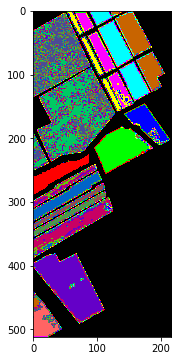

In [50]:
plot_image(data, data_gt, output_background=False)

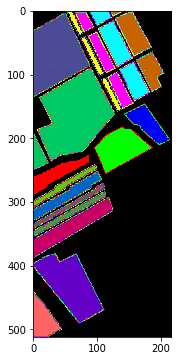

In [51]:
ground_truth = spectral.imshow(classes=data_gt, figsize=(6, 6))